In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import sys
sys.path.insert(1, '../../utils/')
import src_utils
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scipy

# 1. Set rcParams

In [85]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['axes.linewidth'] = 0.5

plt.rcParams["figure.dpi"] = 300

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# 2. Set up grid

"f3_ax1.set_title('gs[0, 0]')\nf3_ax2.set_title('gs[0, 1]')\nf3_ax3.set_title('gs[1:, 0]')\nf3_ax4.set_title('gs[1, 1]')\nf3_ax5.set_title('gs[2, 0]')\nf3_ax6.set_title('gs[2, 1]')\nf3_ax7.set_title('gs[:, 2]')"

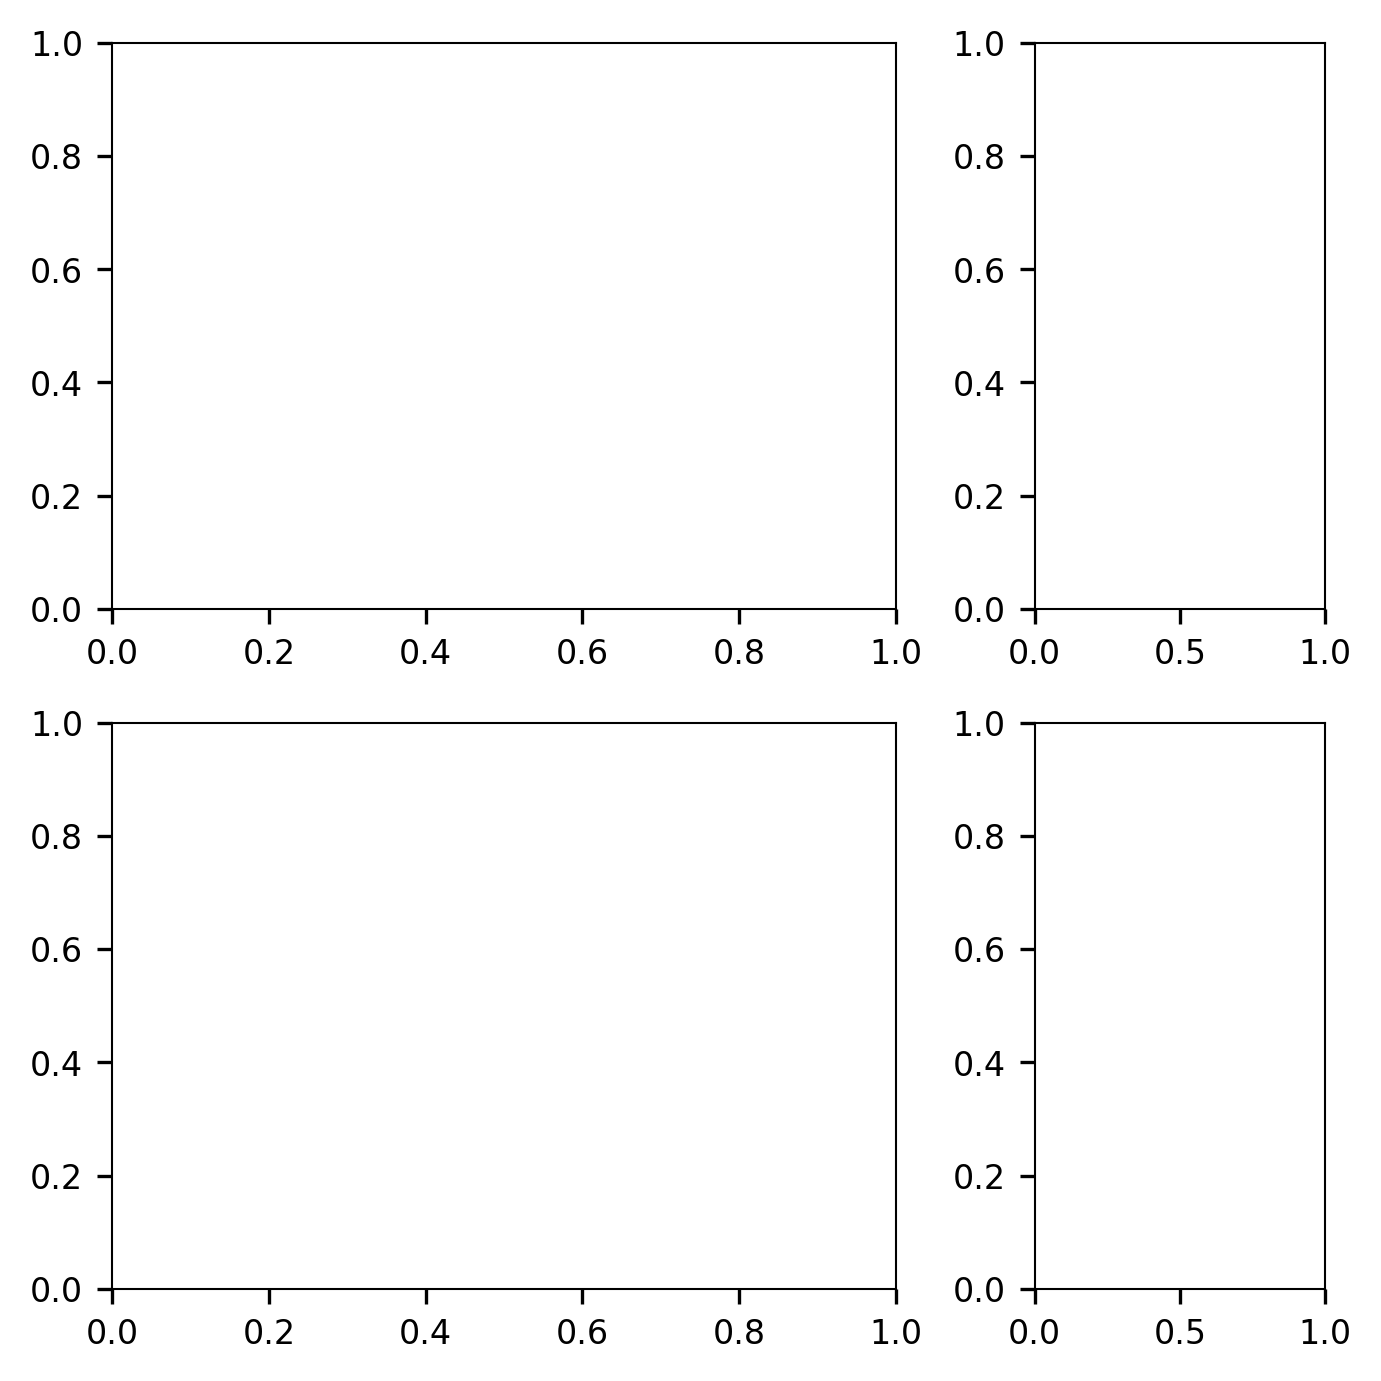

In [86]:
width = 114 / 25.4
height = 114 / 25.4
fig3 = plt.figure(constrained_layout=True, figsize=(width, height))
gs = fig3.add_gridspec(2, 5)
f3_ax1 = fig3.add_subplot(gs[0, :3])
f3_ax2 = fig3.add_subplot(gs[1, :3])
f3_ax3 = fig3.add_subplot(gs[0, 3:])
f3_ax4 = fig3.add_subplot(gs[1, 3:])


"""f3_ax1.set_title('gs[0, 0]')
f3_ax2.set_title('gs[0, 1]')
f3_ax3.set_title('gs[1:, 0]')
f3_ax4.set_title('gs[1, 1]')
f3_ax5.set_title('gs[2, 0]')
f3_ax6.set_title('gs[2, 1]')
f3_ax7.set_title('gs[:, 2]')"""


# Read in necessary data

In [87]:
# All residual values
resid_map = pd.read_csv('../heatmaps/raw_resid_heatmap.csv', index_col=0)

# Client masks
client_mask = np.loadtxt('../../utils/analysis_utils/client_mask.csv').astype(bool)
strong_client_mask = np.loadtxt('../../utils/analysis_utils/strong_client_mask.csv').astype(bool)
ihb_client_mask = np.loadtxt('../../utils/analysis_utils/inhibited_clients.csv').astype(bool)
dep_client_mask = np.loadtxt('../../utils/analysis_utils/dependent_clients.csv').astype(bool)

# A. Windowed average

In [88]:
# Calculate moving average of client scores
def moving_average(a, n=10) :
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

pos_resid_ave = resid_map.mean(axis=1, skipna=True).values
windowed_resids = moving_average(pos_resid_ave)

f3_ax1.plot(np.linspace(270, 520, num=len(windowed_resids)), windowed_resids, c='k')
f3_ax1.set_ylabel('Average client score')
f3_ax1.set_xlabel('Position')
f3_ax1.spines['top'].set_visible(False)
f3_ax1.spines['right'].set_visible(False)

# B. Inhibited vs dependent clients by position

In [89]:
num_dep = np.sum(dep_client_mask * 1, axis=1)
num_ihb = np.sum(ihb_client_mask * 1, axis=1)

cmap = matplotlib.cm.get_cmap('bwr')
dep = cmap(0.3)
ihb = cmap(0.8)

pos_arr = np.arange(270, 520)
f3_ax2.bar(pos_arr, num_dep, color=dep, label='Dependent clients')
f3_ax2.bar(pos_arr, num_ihb, color=ihb, bottom=num_dep, label='Inhibited clients')
f3_ax2.set_yticks([5,10,15,20])
f3_ax2.set_xlabel('Position')
f3_ax2.set_ylabel('Number of clients')
f3_ax2.legend()
f3_ax2.spines['top'].set_visible(False)
f3_ax2.spines['right'].set_visible(False)


# D. Difference from median score

In [90]:
# Types of mutants in clients
client_muts = np.sum(client_mask, axis=0)
nonclient_muts = np.sum(~client_mask, axis=0)
client_med_aa = np.nanmedian(resid_map.values, axis=0)
total_muts = np.sum(~np.isnan(resid_map.values), axis=0)

# Percent clients
perc_client = client_muts / total_muts

# Dictionary for ticks
inv_aa_idx_dict = inv_map = {v: k for k, v in src_utils.__aa_idx_dict__.items()}

# Calculate median and mean
med_num_client = np.median(client_muts)
med_client_score = np.nanmedian(client_med_aa)
med_perc = np.nanmedian(perc_client)

# Median effect scores
#fig, ax = plt.subplots(figsize=(width, height), dpi=300)

# Set tick labels and locations
y_pos = list(inv_aa_idx_dict.keys())
tick_labels = inv_aa_idx_dict.values()

# Set color
color_bars = []
for val in client_med_aa[:-1] - med_client_score:
    if val > 0:
        color_bars.append(ihb)
    else:
        color_bars.append(dep)
# Plot bars
f3_ax4.barh(y_pos[:-1], client_med_aa[:-1] - med_client_score, align='center', label='Clients', color=color_bars)
f3_ax4.axvline(0, c='k')

# Relabel ticks
f3_ax4.set_yticks(y_pos[:-1])
f3_ax4.set_yticklabels(list(tick_labels)[:-1])
f3_ax4.set_xticks([-0.03, 0, 0.03])
f3_ax4.set_xticklabels([-0.03, 0, 0.03])
f3_ax4.invert_yaxis()  # labels read top-to-bottom

# Label axes
f3_ax4.set_xlabel('Ave(score) - median')
f3_ax4.set_ylabel('Amino acid')

Text(935.8369588210255, 0.5, 'Amino acid')

In [92]:
fig3.savefig('../../Figures/manuscript_figs/fig3_drafts/f3_v3.png')